In [10]:
import numpy as np
import pandas as pd
import os, sys
import glob
import tensorflow as tf
from tensorflow import keras
from scipy.fftpack import fft,ifft
import matplotlib.pyplot as plt
## Imports: Keras Models
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.models import Sequential, Model
from keras.layers import Cropping2D
from keras.layers.core import Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import random
from sklearn.model_selection import train_test_split

import csv
import numpy as np
import os
import sklearn
import siina

richwater_path = "/home/birdfly/Data/Rada/richwater/"
broken_path = "/home/birdfly/Data/Radar/broken/"
empty_path = "/home/birdfly/Data/Radar/empty/"
normal_path = "/home/birdfly/Data/Radar/normal/"

In [11]:
def transfer_time_to_freq(data, samplefrequency, freq_from, freq_to):
    """ Transfer time series data to frequency data.
    
    Parameters:
    data: DZT Numpy data N*M, where N is the number of channels and M is the number of times.
    samplefrequency: sample frequency of DZT data. For example, 250.(Hz).
    freq_from: Lower bound of frequency band width. For example, 0.
    freq_to: Upper bound of frequency band width. For example, 50.
    
    Returns:
    --------
    freq_data: (N*(freq_to-freq_from)) * 1 matrix, where N is the number of channels. pd dataframe.
    """
    freq_data = []
    for chaneldata in data:  
        fft_y=fft(chaneldata)
        T = 1/samplefrequency 
        N = chaneldata.size
        freq_data_row = np.abs(fft_y)[:N // 2] * 1 / N
        freq_data.extend(freq_data_row[freq_from:freq_to])
    
    return freq_data

In [12]:
def read_dzt_file(filepath):
    """ Read DZT file from a given path.
    
    Parameter: 
    filepath: str
    Path to a dzt-file
    
    Returns
    -------
    header : dictionary
        First header, length of 1024 bytes, unpacked.
        Other headers are found as a list of bytes under 'other_headers'.
    data : list of numpy arrays
        Each channel in Fortran (column oriented) format.
        In case of failing to reshape, returns one numpy array in a list.
        Error message is found in the header-dict. 
    """
    meas = siina.Radar()
    meas.read_file(filepath)

    return meas.header, meas.data

In [13]:
def read_directory(filepaths):
    """ Read all the files in the given pathes.
    
    Parameter:
    filepaths: a list of paths, where each path contains a category of files.
        For ex, [richwater_path, broken_path]
    
    Returns:
    --------
    X_train: the training data set.
    y_train: the label of training data set.
    """
    X_train = []
    Y_train = []
    category = 0
    
    for filepath in filepaths:
        files = glob.glob(filepath + "/*.DZT")
        for file in files:
            try:
                header, data = read_dzt_file(file) 
                samplefrequency = 1.0/header['samples_per_second'] 
                if data.shape[0]!=1024:
                    continue
                freqdata = transfer_time_to_freq(data, samplefrequency, 0, 25)
                X_train.append(freqdata)
                Y_train.append(category)   
            except:
                print("error file:", file)
        category = category + 1
           
    print(len(X_train))
    X_train = np.asarray(X_train)
    Y_train = tf.keras.utils.to_categorical(y=Y_train, num_classes=len(filepaths))
    
    return X_train, Y_train

In [14]:
def run_model(x_train, y_train, x_test, y_test):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(25*1024, activation='relu'),
        tf.keras.layers.Dense(1024, activation='relu'), 
        tf.keras.layers.Dense(100, activation='relu'),     
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])

    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs= 10)
    model.evaluate(x_test, y_test)
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    model.save('model.h5')
    print('model.h5 has been saved.')

390
Train on 312 samples
Epoch 1/10
312/312 [==============================] - 23s 74ms/sample - loss: 0.5112 - accuracy: 0.0000e+00
Epoch 2/10
312/312 [==============================] - 18s 59ms/sample - loss: 0.5000 - accuracy: 0.0032
Epoch 3/10
312/312 [==============================] - 18s 59ms/sample - loss: 0.4103 - accuracy: 0.1827
Epoch 4/10
312/312 [==============================] - 18s 59ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/10
312/312 [==============================] - 19s 59ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/10
312/312 [==============================] - 18s 59ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/10
312/312 [==============================] - 18s 59ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/10
312/312 [==============================] - 18s 59ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
312/312 [==============================] - 18s 59ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/10

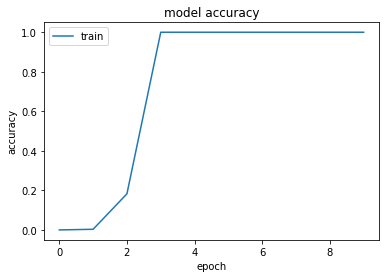

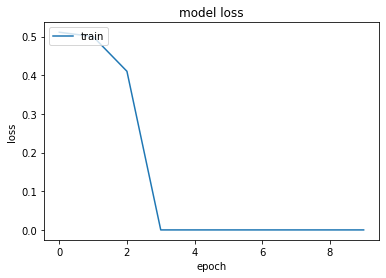

model.h5 has been saved.


In [15]:
if __name__ == "__main__":
    x, y = read_directory([richwater_path, broken_path])
    
    x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=42)

    run_model(x_train, y_train, x_test, y_test)

In [18]:
x = np.asarray(x, dtype=float)
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=42)

run_model(x_train, y_train, x_test, y_test)

ValueError: setting an array element with a sequence.

In [24]:
pd.DataFrame(x[0]).T.values.tolist()

[[256.0,
  2.2403476496790595e-14,
  1.7005586010706614e-14,
  1.4925207190452622e-14,
  2.0716767280201212e-15,
  4.595502575374648e-14,
  4.963330525806172e-15,
  1.3220492124606344e-14,
  3.383302728906725e-14,
  3.337067093876852e-14,
  1.8919692619462932e-14,
  2.4221879478040582e-14,
  6.391504432736771e-14,
  3.352261701290863e-14,
  4.853323986055492e-14,
  6.915633555450783e-14,
  1.0791396413373074e-13,
  1.0476849433521377e-13,
  1.0162208522161897e-13,
  8.842768672661117e-14,
  1.1375828345602459e-13,
  9.937654562552934e-14,
  1.009853848359671e-13,
  1.013736444382089e-13,
  1.0489303522952712e-13,
  8.558953215697856e-14,
  9.692454477580987e-14,
  9.101945022628205e-14,
  9.40543179780221e-14,
  8.856696597084596e-14,
  9.001193288872652e-14,
  8.189837014279008e-14,
  8.105332824600673e-14,
  7.681086144500937e-14,
  7.746627753761553e-14,
  7.474843542670458e-14,
  6.872201046454836e-14,
  6.642794205118613e-14,
  7.143800503333223e-14,
  6.586528929281185e-14,
  7.0